In [ ]:
import os

os.environ["CHECKPOINTS_PATH"] = "../checkpoints"
os.environ["TRACKING_RESULTS_PATH"] = "data/processed_tracking_results"

import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from src.aliases import UInt8Array
from src.api.models.pydantic import SimRoomClassDTO
from src.api.models.vector_index import FAISSIndexWithMetadata
from src.api.services import embeddings_service, simrooms_service, labeling_service
from src.api.repositories import simrooms_repo

from experiment.settings import (
    DIFF_BACKGROUND_INDEXES_PATH,
    LABELING_REC_DIFF_BACKGROUND_ID,
    LABELING_REC_SAME_BACKGROUND_ID,
    SAME_BACKGROUND_INDEXES_PATH,
    SIMROOM_ID,
)
from src.api.db import Session, engine

2025-05-16 19:32:22.416311: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 19:32:22.428858: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747416742.439273  141342 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747416742.441998  141342 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-16 19:32:22.456096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Creating Embeddings from Annotations for each Class:

Some important notes here:

We should probably be setting a minimum sample count per class when labeling. 
Additionally, we should set an upper bound on the number of samples per class added to the database, based on the lowest amount of samples available for the classes.

Question: Should we do data augmentation as well?

The following are some interesting parameters to experiment with based on experimentation on real-world data:
1. Sample count per class
2. Data augmentation (and which kinds?)
3. Same number of samples per class or not?
4. ?

In [2]:
def get_annotated_samples(
    calibration_id: int,
    tracked_classes: list[SimRoomClassDTO],
) -> tuple[list[UInt8Array], list[int]]:
    rois = []
    class_ids = []
    mask_areas = []

    # Check if there are enough samples for each class
    for tracked_class in tracked_classes:
        result_paths = labeling_service.get_class_tracking_results(
            calibration_id=calibration_id, class_id=tracked_class.id
        )
        for result_path in result_paths:
            file = np.load(result_path)
            mask_area = np.sum(file["mask"])
            rois.append(file["roi"])
            class_ids.append(int(file["class_id"]))
            mask_areas.append(mask_area)

    return rois, class_ids, mask_areas


def select_samples(
    class_ids: list[int], min_samples_per_class: int
) -> tuple[list[UInt8Array], list[int]]:
    class_ids_np: UInt8Array = np.array(class_ids)
    selected_indices = []
    for cls in np.unique(class_ids_np):
        cls_indices = np.where(cls == class_ids_np)[0]
        # Randomly choose N indices if more than N available, otherwise take all indices
        if len(cls_indices) > min_samples_per_class:
            chosen = np.random.choice(
                cls_indices, size=min_samples_per_class, replace=False
            )
        else:
            chosen = cls_indices
        selected_indices.extend(chosen)

    return np.array(selected_indices)


def create_vector_index(
    dinov2,
    calibration_id: int,
    min_samples_per_class: int,
    output_path: Path,
    tracked_classes: list[SimRoomClassDTO],
):
    rois, class_ids, mask_areas = get_annotated_samples(calibration_id, tracked_classes)

    selected_indices = select_samples(class_ids, min_samples_per_class)
    rois = [rois[i] for i in selected_indices]
    class_ids = [class_ids[i] for i in selected_indices]
    mask_areas = [mask_areas[i] for i in selected_indices]

    # Show a sample as a sanity check
    sample_idx = 0
    roi = rois[sample_idx]
    print(f"Mask area: {mask_areas[sample_idx]}")
    plt.title(f"Class ID: {class_ids[sample_idx]}")
    plt.imshow(roi)
    plt.show()

    index = FAISSIndexWithMetadata(dim=embeddings_service.EMBEDDING_DIM)
    for embeddings, batch_start, batch_end in embeddings_service.get_embeddings(
        dinov2, rois, log_performance=True
    ):
        batch_class_ids = class_ids[batch_start:batch_end]
        batch_mask_areas = mask_areas[batch_start:batch_end]
        metadata = [
            {"mask_area": int(mask_area), "class_id": int(class_id)}
            for mask_area, class_id in zip(
                batch_mask_areas, batch_class_ids, strict=False
            )
        ]

        index.add(embeddings, metadata)

    index.write(output_path)

In [3]:
dinov2 = embeddings_service.load_model()

Found 1410 samples for class naaldcontainer
Found 814 samples for class spuit
Found 891 samples for class keukenmes
Found 786 samples for class infuus
Found 976 samples for class stethoscoop
Found 861 samples for class bol wol
Found 932 samples for class snoep
Found 897 samples for class nuchter
Found 847 samples for class fotokader
Found 791 samples for class iced tea
Found 840 samples for class bril
Found 833 samples for class scherm
Found 874 samples for class rollator
Found 648 samples for class ampulevloeistof
Found 1116 samples for class ampulepoeder
Minimum samples per class: 648
Mask area: 1227


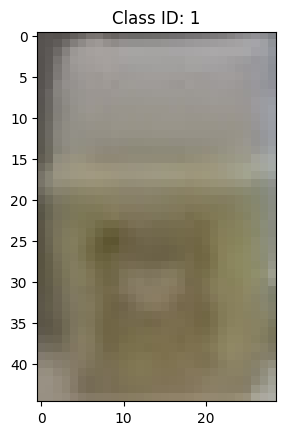

Generated 1500 embeddings at 383.98 samples per second
Mask area: 3928


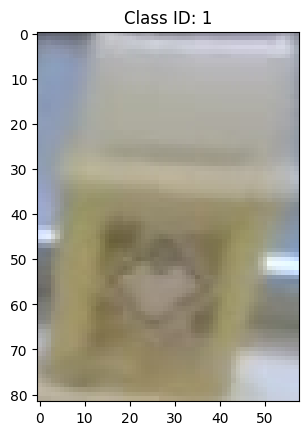

Generated 3000 embeddings at 399.83 samples per second
Mask area: 6463


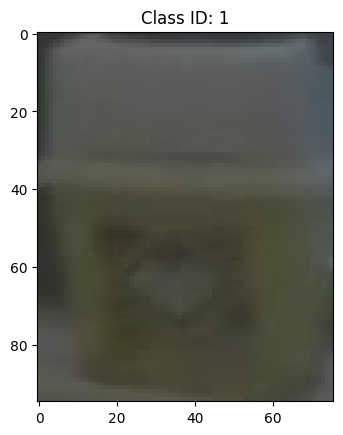

Generated 4500 embeddings at 415.27 samples per second
Mask area: 21411


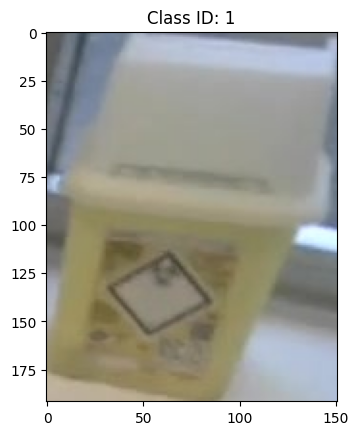

Generated 6000 embeddings at 393.84 samples per second
Mask area: 2186


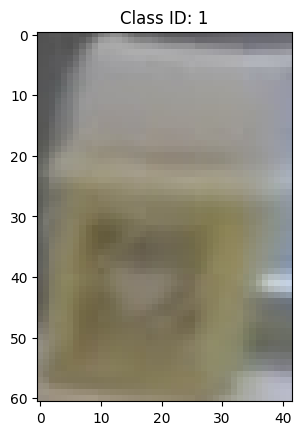

Generated 7500 embeddings at 399.01 samples per second
Mask area: 43777


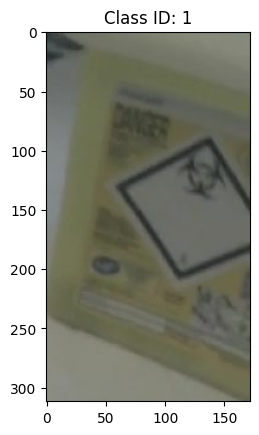

Generated 9000 embeddings at 431.47 samples per second
Mask area: 2493


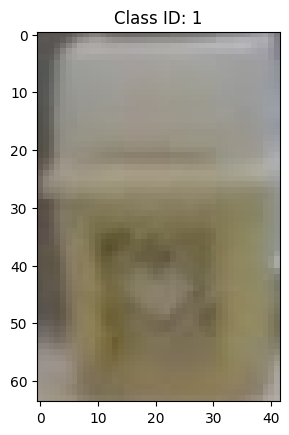

Generated 9720 embeddings at 444.85 samples per second


In [4]:
if SAME_BACKGROUND_INDEXES_PATH.exists():
    shutil.rmtree(SAME_BACKGROUND_INDEXES_PATH)
if DIFF_BACKGROUND_INDEXES_PATH.exists():
    shutil.rmtree(DIFF_BACKGROUND_INDEXES_PATH)
SAME_BACKGROUND_INDEXES_PATH.mkdir(parents=True, exist_ok=True)
DIFF_BACKGROUND_INDEXES_PATH.mkdir(parents=True, exist_ok=True)


def create_vector_indexes(
    session, dinov2, calibration_id: int, vector_indexes_path: Path
):
    tracked_classes = simrooms_service.get_tracked_classes(
        db=session, calibration_id=same_background_calibration_id
    )

    min_samples_per_class = 100000000000
    for tracked_class in tracked_classes:
        result_paths = simrooms_repo.get_tracking_result_paths(
            session, same_background_calibration_id, tracked_class.id
        )

        print(f"Found {len(result_paths)} samples for class {tracked_class.class_name}")

        if len(result_paths) < min_samples_per_class:
            min_samples_per_class = len(result_paths)

    print(f"Minimum samples per class: {min_samples_per_class}")

    samples_per_class = [100, 200, 300, 400, 500, 600, min_samples_per_class]

    for samples in samples_per_class:
        output_path = vector_indexes_path / f"{samples}_samples_per_class.index"
        create_vector_index(dinov2, calibration_id, samples, output_path, tracked_classes)


with Session(engine) as session:
    same_background_calibration_id = simrooms_repo.get_calibration_recording(
        db=session, simroom_id=SIMROOM_ID, recording_id=LABELING_REC_SAME_BACKGROUND_ID
    ).id
    diff_background_calibration_id = simrooms_repo.get_calibration_recording(
        db=session, simroom_id=SIMROOM_ID, recording_id=LABELING_REC_DIFF_BACKGROUND_ID
    ).id

    create_vector_indexes(
        session, dinov2, same_background_calibration_id, SAME_BACKGROUND_INDEXES_PATH
    )
# create_vector_indexes(dinov2, diff_background_calibration_id, DIFF_BACKGROUND_INDEXES_PATH)